<a href="https://colab.research.google.com/github/pkrishna1801/Sentiment-analysis-using-Roberta/blob/main/Copy_of_RoBERTa_Unhealthy_Comment_Corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The plan for fine-tuning RoBERTa with the UCC

### 1. Set up
- Install transformers and pytorch lightning and import required packages.
- Loads UCC data and inspect it.

### 2. Create a dataset

- Load data into pytorch dataset

### 3. Build the model
 - Create a new pytorch (lightning) model with the Hugging Face RoBERTa model and a multi-label classification head.

### 4. Test model performance
- Test model performance using the ROC AUC and same test-set used in the original paper.

In [ ]:
!nvidia-smi

Mon Mar 24 16:44:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   39C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Imports

In [ ]:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121
%pip install transformers
%pip install pytorch-lightning
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install tensorboard


Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from transformers import (
    AutoModel,
    AutoTokenizer,
    get_cosine_schedule_with_warmup
)
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
from typing import Optional, Dict, List

# Check versions and CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU count: {torch.cuda.device_count()}")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU count: 1


In [ ]:
train_path = '/content/train.csv'
val_path = '/content/val.csv'

In [ ]:
train_data = pd.read_csv(train_path)

In [ ]:
train_data.head(5)

,_unit_id,_trusted_judgments,comment,antagonize,antagonize:confidence,condescending,condescending:confidence,dismissive,dismissive:confidence,generalisation,generalisation:confidence,generalisation_unfair,generalisation_unfair:confidence,healthy,healthy:confidence,hostile,hostile:confidence,sarcastic,sarcastic:confidence
0,2319157561,4,"Three marriages, several bankrupt periods, inh...",0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,0.7578,0,0.7565,0,1.0000
1,1739464982,4,The sense of entitlement among high school 'jo...,0,0.7634,0,0.7634,0,0.7634,0,1.0000,0.0,1.0,1,0.7634,0,0.7634,0,0.7634
2,1739457583,5,So what? He was just stating the obvious.,0,0.8121,0,0.5928,0,0.8043,0,1.0000,0.0,1.0,1,0.6163,0,1.0000,0,1.0000
3,2319156950,40,"If one is a Con, why yes, one would honk. Loud...",0,0.8508,0,0.8867,0,0.9239,0,0.8863,0.0,1.0,1,0.8508,0,0.9641,0,0.8868
4,2327196492,3,Ooohhh... It's Wendy Whiner... making sure to ...,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,1.0000,0,1.0000,0,1.0000


# inspect data

<Axes: >

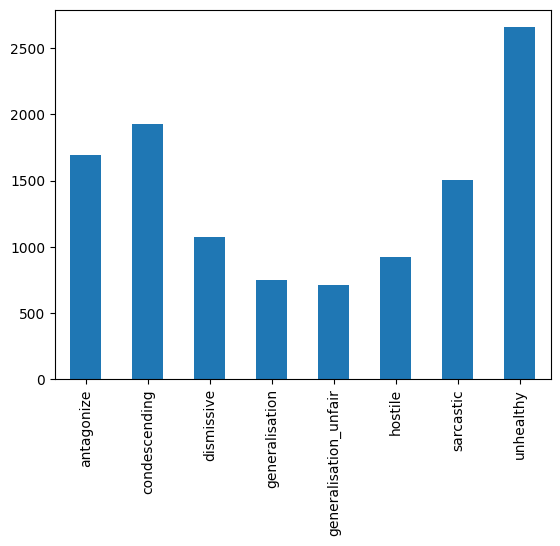

In [ ]:
train_data['unhealthy'] = np.where(train_data['healthy'] == 1, 0, 1)

attributes = ['antagonize', 'condescending','dismissive','generalisation',
              'generalisation_unfair','hostile','sarcastic','unhealthy']

train_data[attributes].sum().plot.bar()

# Dataset

In [ ]:
class UCCDataset(Dataset):
    """Dataset class for Unhealthy Comment Corpus (UCC)

    Args:
        data_path (str): Path to the CSV data file
        tokenizer: HuggingFace tokenizer
        attributes (List[str]): List of target attributes to predict
        max_token_len (int): Maximum token length for padding/truncation
        sample (Optional[int]): Number of samples to use (for balanced sampling)
    """
    def __init__(
        self,
        data_path: str,
        tokenizer,
        attributes: List[str],
        max_token_len: int = 128,
        sample: Optional[int] = None
    ):
        self.tokenizer = tokenizer
        self.attributes = attributes
        self.max_token_len = max_token_len
        self.data = self._prepare_data(data_path, sample)

    def _prepare_data(self, data_path: str, sample: Optional[int]) -> pd.DataFrame:
        data = pd.read_csv(data_path)
        data['unhealthy'] = np.where(data['healthy'] == 1, 0, 1)

        # Convert all attribute columns to float type
        for attr in self.attributes:
            data[attr] = data[attr].astype(float)

        if sample:
            unhealthy = data[data[self.attributes].sum(axis=1) > 0]
            clean = data[data[self.attributes].sum(axis=1) == 0]
            return pd.concat([
                unhealthy,
                clean.sample(sample, random_state=42)
            ]).reset_index(drop=True)
        return data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        row = self.data.iloc[index]

        # Encode text
        encoding = self.tokenizer(
            str(row.comment),
            add_special_tokens=True,
            max_length=self.max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Get labels and ensure they are float type
        labels = torch.tensor(
            self.data.iloc[index][self.attributes].values.astype(float),
            dtype=torch.float
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels
        }

In [ ]:
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
ucc_ds = UCCDataset(train_path, tokenizer, attributes=attributes, max_token_len=128)
ucc_ds_val = UCCDataset(val_path, tokenizer, attributes=attributes, max_token_len=128, sample=None)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
ucc_ds.__getitem__(0)

{'input_ids': tensor([    0, 19897, 29846,     4,    38,    64,    75,   679, 46301,    74,
          9802,   132,     9,    39,   308,    95,     7,  1471,   559,   332,
             8,   146,  7064,   356,  1099,     4,   370,   214,   235,     6,
         46301,    16,    10, 34759,     4,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [ ]:
ucc_ds.__getitem__(0)['labels'].shape, ucc_ds.__getitem__(0)['input_ids'].shape, ucc_ds.__getitem__(0)['attention_mask'].shape

(torch.Size([8]), torch.Size([128]), torch.Size([128]))

In [ ]:
len(ucc_ds)

9960

In [ ]:
len(ucc_ds_val)

4427

# Data module

In [ ]:
class UCCDataModule(pl.LightningDataModule):
    """PyTorch Lightning DataModule for UCC dataset

    Args:
        train_path (str): Path to training data
        val_path (str): Path to validation data
        attributes (List[str]): Target attributes to predict
        batch_size (int): Batch size for training
        max_token_length (int): Maximum token length
        model_name (str): HuggingFace model name
        num_workers (int): Number of workers for DataLoader
    """
    def __init__(
        self,
        train_path: str,
        val_path: str,
        attributes: List[str],
        batch_size: int = 32,
        max_token_length: int = 128,
        model_name: str = 'roberta-base',
        num_workers: int = 4
    ):
        super().__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.attributes = attributes
        self.batch_size = batch_size
        self.max_token_length = max_token_length
        self.model_name = model_name
        self.num_workers = num_workers
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def setup(self, stage: Optional[str] = None):
        if stage in (None, "fit"):
            self.train_dataset = UCCDataset(
                self.train_path,
                self.tokenizer,
                self.attributes
            )
            self.val_dataset = UCCDataset(
                self.val_path,
                self.tokenizer,
                self.attributes,
                sample=None
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True
        )

In [ ]:
ucc_data_module = UCCDataModule(
    train_path=train_path,
    val_path=val_path,
    attributes=attributes,
    batch_size=32,
    max_token_length=128,
    model_name='roberta-base',
    num_workers=4
)

In [ ]:
ucc_data_module.setup()

In [ ]:
ucc_data_module.train_dataloader()

In [ ]:
# Number of batches (9960 // 16 = 623)
len(ucc_data_module.train_dataloader())

312

# Model

In [ ]:
class UCCClassifier(pl.LightningModule):
    """Multi-label classifier for UCC using RoBERTa

    Args:
        config (Dict): Configuration dictionary containing model parameters
    """
    def __init__(self, config: Dict):
        super().__init__()
        self.save_hyperparameters(config)

        self.pretrained_model = AutoModel.from_pretrained(
            config['model_name'],
            return_dict=True
        )
        self.hidden = nn.Linear(
            self.pretrained_model.config.hidden_size,
            self.pretrained_model.config.hidden_size
        )
        self.classifier = nn.Linear(
            self.pretrained_model.config.hidden_size,
            config['n_labels']
        )
        self.dropout = nn.Dropout(p=0.1)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.pretrained_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = torch.mean(outputs.last_hidden_state, 1)

        hidden_output = self.dropout(F.relu(self.hidden(pooled_output)))
        logits = self.classifier(hidden_output)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return loss, logits

    def training_step(self, batch):
        loss, _ = self(**batch)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch):
        loss, logits = self(**batch)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return {"val_loss": loss, "predictions": logits, "labels": batch["labels"]}

    def configure_optimizers(self):
        # Assuming val_data or train_data contains the true labels (multi-hot encoded)
        optimizer = AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )

        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(self.hparams.warmup * self.hparams.train_steps),
            num_training_steps=self.hparams.train_steps
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step"
            }
        }

## Training setup

In [ ]:
# Set environment variable to avoid tokenizer warnings
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Configuration
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 32,
    'lr': 2e-5,
    'warmup': 0.1,
    'weight_decay': 0.01,
    'n_epochs': 10,
    'train_steps': len(ucc_data_module.train_dataloader()) * 5  # total steps for 5 epochs
}

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='ucc-roberta-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    mode='min',
    save_top_k=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)

# Logger
logger = TensorBoardLogger("lightning_logs", name="ucc_classifier")

# Trainer
trainer = pl.Trainer(
    max_epochs=config['n_epochs'],
    accelerator='gpu',
    devices=1,  # Use single GPU
    callbacks=[checkpoint_callback, early_stopping],
    logger=logger,
    gradient_clip_val=1.0,
    log_every_n_steps=10
)

# Model
model = UCCClassifier(config)

# Initialize the model's pooler weights from pretrained
model.pretrained_model.init_weights()

# Train
trainer.fit(model, ucc_data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params | Mode 
---------------------------------------------------------------
0 | pretrained_model | RobertaModel      | 82.1 M | eval 
1 | hidden           | Linear            | 590 K  | train
2 | classifier       | Linear            | 6.2 K  | train
3 | dropout          | Dropout           | 0      | train
4 | loss_fn          | BCEWithLogitsLoss | 0      | train
---------------------------------------------------------------


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Predict with model

In [ ]:
def classify_raw_comments(model, dm):
    predictions = []
    model.eval()
    for batch in dm.val_dataloader():
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        with torch.no_grad():
            _, logits = model(input_ids, attention_mask=attention_mask)  # Unpack loss and logits
            predictions.append(logits)
    flattened_predictions = torch.sigmoid(torch.cat(predictions, dim=0)).cpu().numpy()
    return flattened_predictions

In [ ]:
predictions = classify_raw_comments(model, ucc_data_module)

In [ ]:
val_data = pd.read_csv(val_path)
val_data['unhealthy'] = np.where(val_data['healthy'] == 1, 0, 1)
true_labels = np.array(val_data[attributes])

Text(0.5, 1.0, 'RoBERTa Trained on UCC Datatset - AUC ROC')

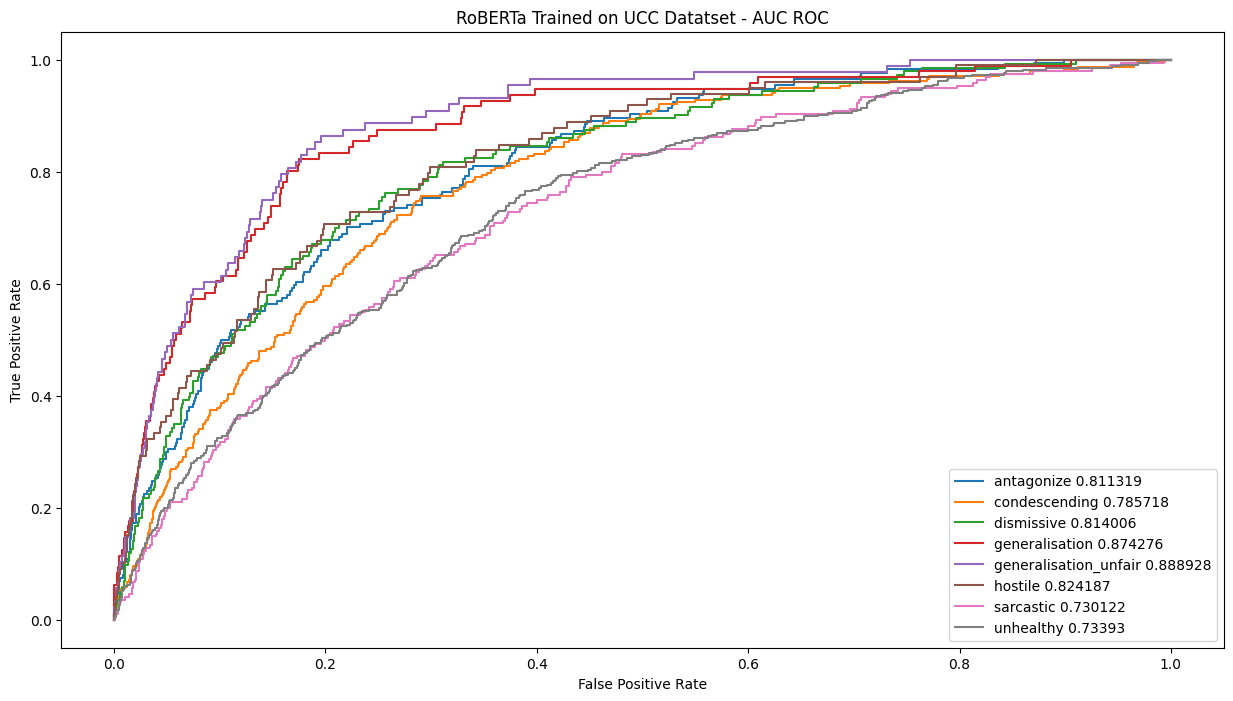

In [ ]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      true_labels[:,i].astype(int), predictions[:, i])
  auc = metrics.roc_auc_score(
      true_labels[:,i].astype(int), predictions[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('RoBERTa Trained on UCC Datatset - AUC ROC')

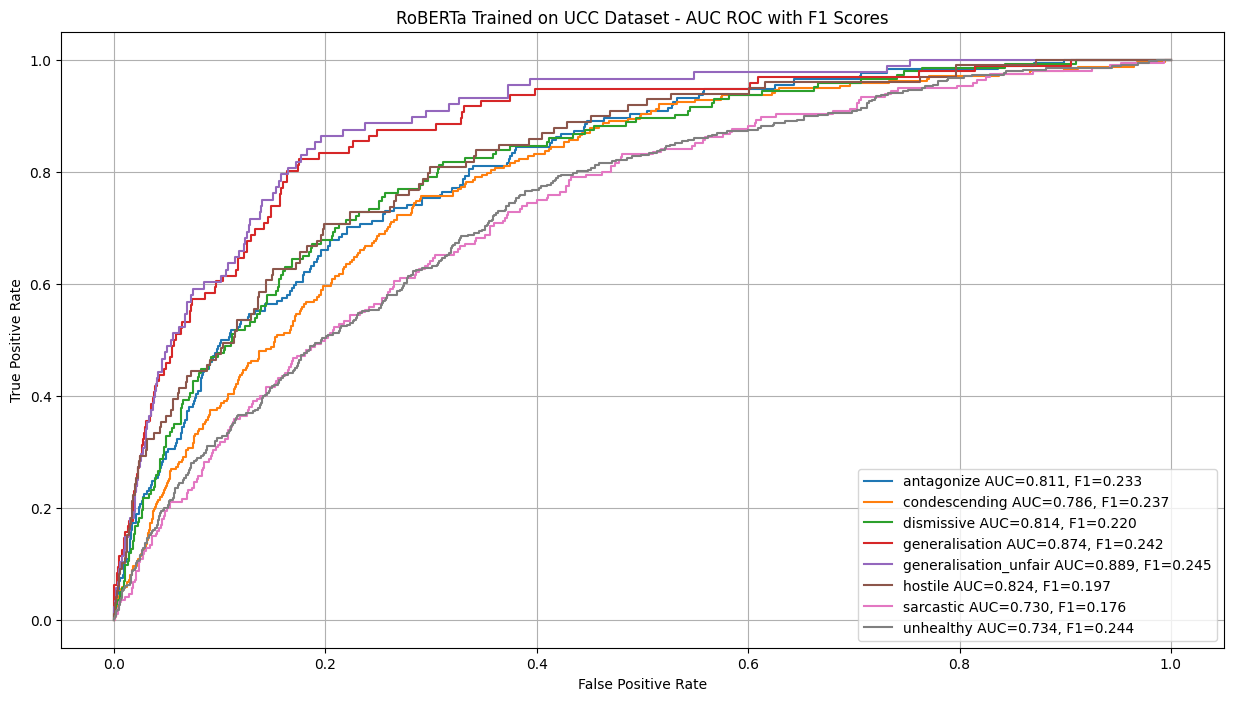

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

plt.figure(figsize=(15, 8))

aucs = []
f1s = []

# You can use a threshold like 0.5 to convert predicted probabilities to binary
threshold = 0.2
binary_predictions = (predictions >= threshold).astype(int)
for i, attribute in enumerate(attributes):
    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    auc = roc_auc_score(true_labels[:, i], predictions[:, i])
    aucs.append(auc)

    # F1 Score
    f1 = f1_score(true_labels[:, i], binary_predictions[:, i])
    f1s.append(f1)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='%s AUC=%.3f, F1=%.3f' % (attribute, auc, f1))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('RoBERTa Trained on UCC Dataset - AUC ROC with F1 Scores')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import f1_score

optimal_thresholds = []
for i in range(len(attributes)):
    best_f1 = 0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.9, 0.01):
        preds_bin = (predictions[:, i] >= thresh).astype(int)
        f1 = f1_score(true_labels[:, i], preds_bin)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    optimal_thresholds.append(best_thresh)
    print(f"{attributes[i]} → Best Threshold = {best_thresh:.2f}, Max F1 = {best_f1:.3f}")


antagonize → Best Threshold = 0.33, Max F1 = 0.252
condescending → Best Threshold = 0.31, Max F1 = 0.248
dismissive → Best Threshold = 0.26, Max F1 = 0.232
generalisation → Best Threshold = 0.33, Max F1 = 0.262
generalisation_unfair → Best Threshold = 0.27, Max F1 = 0.253
hostile → Best Threshold = 0.37, Max F1 = 0.246
sarcastic → Best Threshold = 0.29, Max F1 = 0.187
unhealthy → Best Threshold = 0.42, Max F1 = 0.261


In [ ]:
from sklearn.metrics import f1_score

micro_f1 = f1_score(true_labels, (predictions >= 0.5).astype(int), average='micro')
macro_f1 = f1_score(true_labels, (predictions >= 0.5).astype(int), average='macro')

print("Micro-averaged F1:", micro_f1)
print("Macro-averaged F1:", macro_f1)


Micro-averaged F1: 0.22186182289977294
Macro-averaged F1: 0.2127356428767583


In [ ]:
true_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
true_labels.shape

(4427, 8)

In [ ]:
predictions

array([[0.00792284, 0.00956203, 0.00765454, ..., 0.00786222, 0.05375631,
        0.04725916],
       [0.02924811, 0.18428352, 0.05838716, ..., 0.01265193, 0.07229874,
        0.12088948],
       [0.00705144, 0.01865619, 0.0118132 , ..., 0.00582456, 0.05193952,
        0.05148544],
       ...,
       [0.01401985, 0.06000634, 0.02028849, ..., 0.00698873, 0.34638563,
        0.08797582],
       [0.01006488, 0.00967488, 0.0081563 , ..., 0.00935275, 0.03532845,
        0.07131369],
       [0.00848741, 0.01774703, 0.00994315, ..., 0.00668862, 0.06984508,
        0.06156124]], dtype=float32)

In [ ]:
predictions.shape

(4427, 8)

In [ ]:
binary_predictions

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

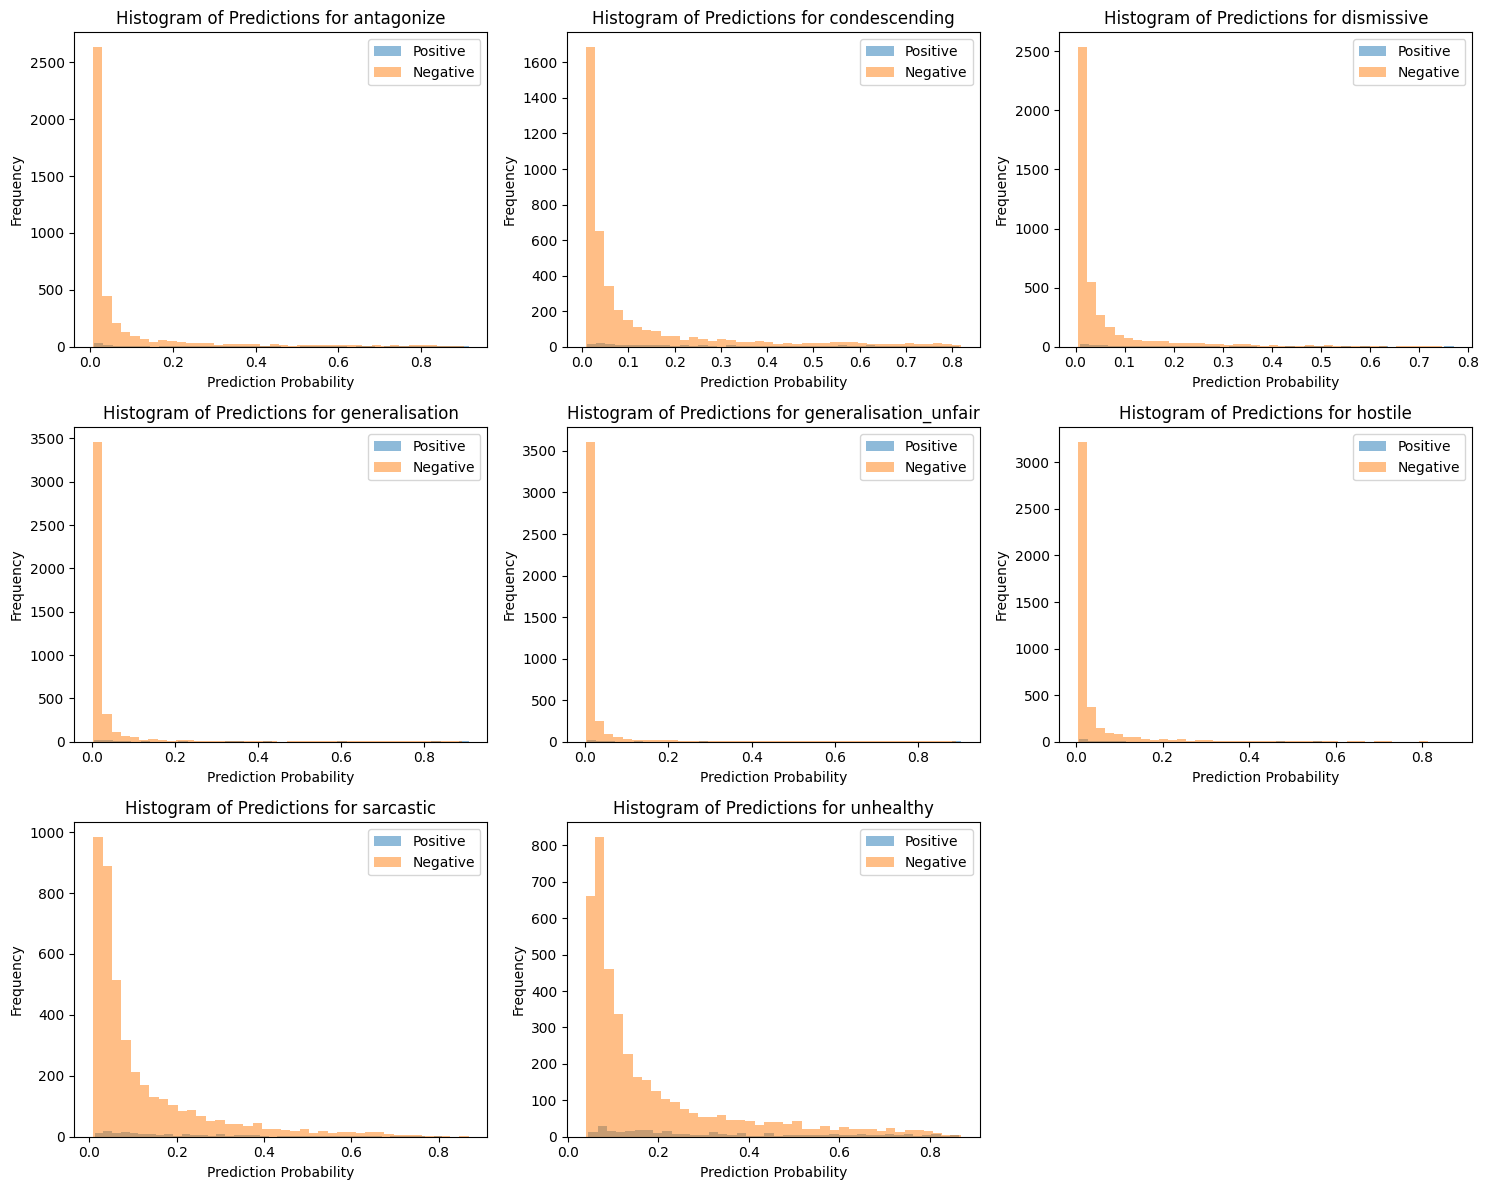

In [ ]:
# prompt: draw histogram of each prediction class into separate plots

plt.figure(figsize=(15, 12))  # Adjust figure size as needed

for i, attribute in enumerate(attributes):
    plt.subplot(3, 3, i + 1)  # Create subplots in a 3x3 grid
    plt.hist(predictions[true_labels[:, i] == 1, i], bins=40, alpha=0.5, label='Positive')
    plt.hist(predictions[true_labels[:, i] == 0, i], bins=40, alpha=0.5, label='Negative')
    plt.title(f'Histogram of Predictions for {attribute}')
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()  # Ensure subplots don't overlap
plt.show()


In [ ]:
predictions[true_labels[:, i] == 1, i]

array([0.04725916, 0.12088948, 0.05148544, ..., 0.08797582, 0.07131369,
       0.06156124], dtype=float32)

In [ ]:
(
true_labels[:, i] == 0
)

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]


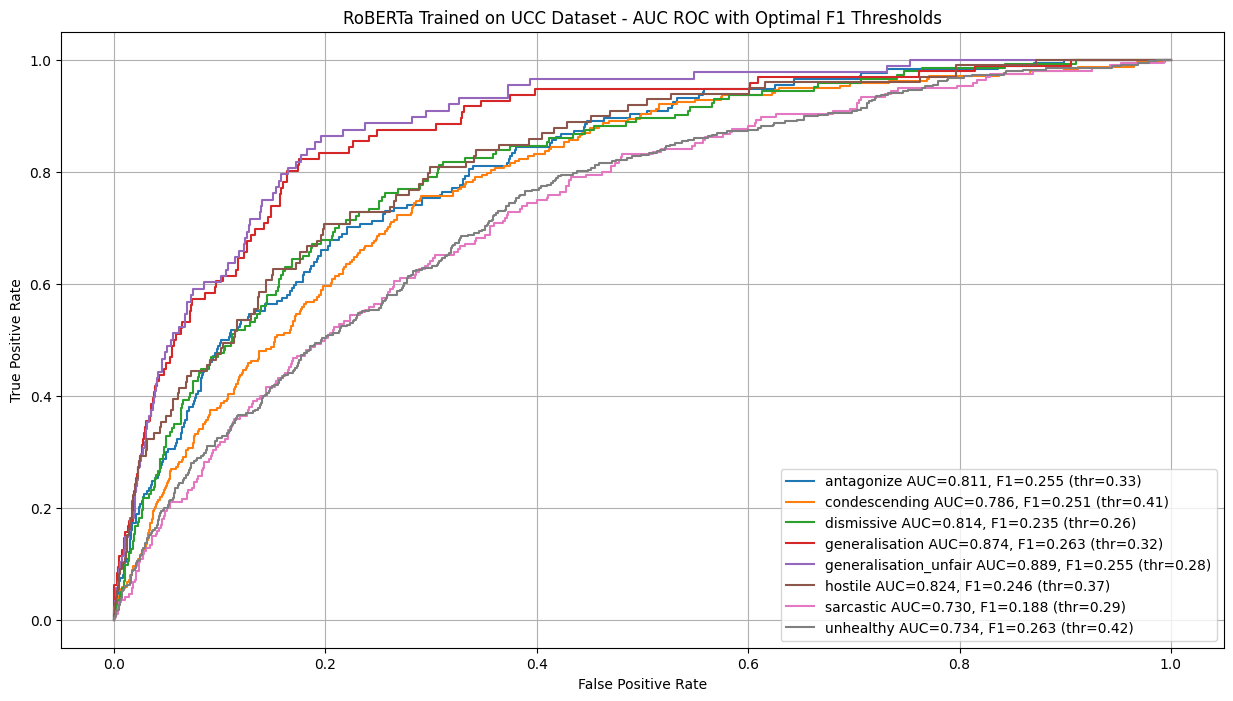

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

aucs = []
f1s = []
optimal_thresholds = []

for i, attribute in enumerate(attributes):
    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    auc = roc_auc_score(true_labels[:, i], predictions[:, i])
    aucs.append(auc)

    # Find optimal threshold using precision-recall curve
    precision, recall, thresholds = precision_recall_curve(true_labels[:, i], predictions[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    optimal_thresholds.append(best_threshold)

    # Compute F1 using the best threshold
    binary_predictions = (predictions[:, i] >= best_threshold).astype(int)
    f1 = f1_score(true_labels[:, i], binary_predictions)
    f1s.append(f1)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='%s AUC=%.3f, F1=%.3f (thr=%.2f)' % (attribute, auc, f1, best_threshold))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('RoBERTa Trained on UCC Dataset - AUC ROC with Optimal F1 Thresholds')
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

class UCCClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.pretrained_model = AutoModel.from_pretrained(
            config['model_name'],
            return_dict=True
        )
        self.hidden = nn.Linear(
            self.pretrained_model.config.hidden_size,
            2*self.pretrained_model.config.hidden_size
        )
        self.classifier = nn.Linear(
            2*self.pretrained_model.config.hidden_size,
            config['n_labels']
        )
        self.dropout = nn.Dropout(p=0.1)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.pretrained_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = torch.mean(outputs.last_hidden_state, dim=1)
        hidden_output = self.dropout(F.relu(self.hidden(pooled_output)))
        logits = self.classifier(hidden_output)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return loss, logits


In [ ]:
from transformers import AdamW, get_cosine_schedule_with_warmup
from tqdm import tqdm

def train(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        loss, _ = model(input_ids, attention_mask, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            loss, logits = model(input_ids, attention_mask, labels)
            total_loss += loss.item()

            all_preds.append(torch.sigmoid(logits).cpu())
            all_labels.append(labels.cpu())

    return total_loss / len(dataloader), torch.cat(all_preds), torch.cat(all_labels)


In [ ]:
import torch
from torch.utils.data import DataLoader

# Config example
config = {
    'model_name': 'roberta-large',
    'n_labels': 8,
    'lr': 2e-5,
    'weight_decay': 0.01,
    'warmup': 0.1,
    'train_steps': 1000
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UCCClassifier(config).to(device)

# Setup optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(config['warmup'] * config['train_steps']),
    num_training_steps=config['train_steps']
)

# Replace with your actual Dataloaders
train_dataloader = ucc_data_module.train_dataloader()
val_dataloader = ucc_data_module.val_dataloader()

# Training loop
for epoch in range(1, 6):
    train_loss = train(model, train_dataloader, optimizer, scheduler, device)
    val_loss, val_preds, val_labels = validate(model, val_dataloader, device)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:  62%|██████▎   | 195/312 [02:58<01:46,  1.10it/s]

In [ ]:
from sklearn.metrics import roc_curve, auc as compute_auc
import matplotlib.pyplot as plt

def plot_multilabel_roc(y_true, y_score, class_names=attributes):
    """
    Plots ROC curve for each class in a multi-label setup.

    Args:
        y_true (ndarray): Ground truth binary labels (num_samples, num_classes)
        y_score (ndarray): Predicted probabilities (num_samples, num_classes)
        class_names (List[str], optional): Names of each class
    """
    n_classes = y_true.shape[1]

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = compute_auc(fpr, tpr)
        label = f"Class {i}" if class_names is None else class_names[i]
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves by Class')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score

def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            loss, logits = model(input_ids, attention_mask, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits)  # probabilities for multilabel classification
            all_preds.append(probs.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Binarize predictions using 0.5 threshold
    binary_preds = (all_preds >= 0.5).astype(int)

    # F1 Score
    f1 = f1_score(all_labels, binary_preds, average='macro')

    # AUC-ROC Score
    try:
        auc_score = roc_auc_score(all_labels, all_preds, average='macro')
    except ValueError:
        auc_score = float('nan')

    # Plot the ROC curves
    plot_multilabel_roc(all_labels, all_preds)

    return total_loss / len(dataloader), f1, auc_score


Validating: 100%|██████████| 139/139 [00:13<00:00, 10.17it/s]


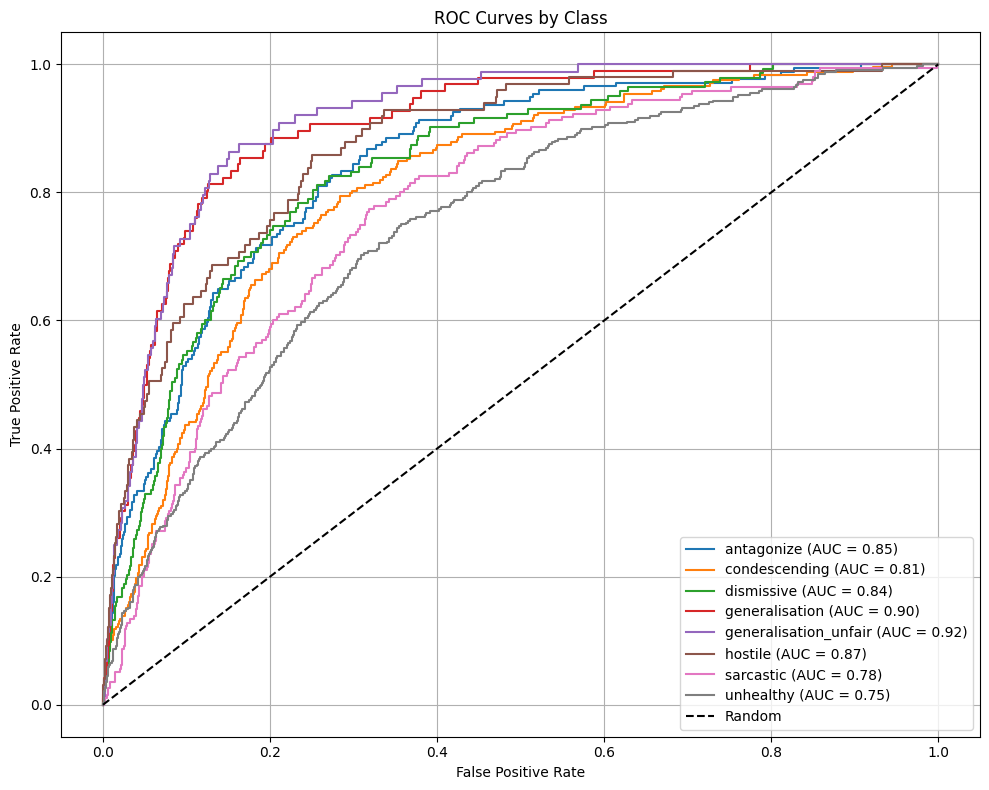


Final Evaluation on Validation Set:
Val Loss: 0.1744
F1 Score (macro): 0.2254
AUC-ROC (macro): 0.8403


In [ ]:
val_loss, val_f1, val_auc = validate(model, val_dataloader, device)
print(f"\nFinal Evaluation on Validation Set:")
print(f"Val Loss: {val_loss:.4f}")
print(f"F1 Score (macro): {val_f1:.4f}")
print(f"AUC-ROC (macro): {val_auc:.4f}")
